In [36]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import subprocess
import os
from pathlib import Path

Fishbone-moncrief

Introducing Aperture, appendix Wald solution

In [37]:
num_outputs = 318

In [38]:
# for i in range(num_outputs):
#     file_in = f"images/failfint_{i:04d}.ppm"
#     file_out = f"vids/ffint_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/failgamc_{i:04d}.ppm"
#     file_out = f"vids/fgamc_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/failu2p3_{i:04d}.ppm"
#     file_out = f"vids/fu2p3_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/failu2p2_{i:04d}.ppm"
#     file_out = f"vids/fu2p2_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/failu2p1_{i:04d}.ppm"
#     file_out = f"vids/fu2p1_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")

In [39]:
# for i in range(num_outputs):
#     file_in = f"images/im_lgam_{i:04d}.ppm"
#     file_out = f"vids/im_lgam_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/im_lbsq_{i:04d}.ppm"
#     file_out = f"vids/im_lbsq_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/im_lu_{i:04d}.ppm"
#     file_out = f"vids/im_lu_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/im_lrho_{i:04d}.ppm"
#     file_out = f"vids/im_lrho_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/im_gam_{i:04d}.ppm"
#     file_out = f"vids/im_gam_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/im_bsq_{i:04d}.ppm"
#     file_out = f"vids/im_bsq_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/im_u_{i:04d}.ppm"
#     file_out = f"vids/im_u_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")
#     file_in = f"images/im_rho_{i:04d}.ppm"
#     file_out = f"vids/im_rho_{i:04d}.png"
#     im = Image.open(file_in)
#     im.save(file_out, "PNG")

In [40]:
# fileList = ['im_lgam', 'im_lbsq', 'im_lu', 'im_lrho', 'im_gam', 'im_bsq', 'im_u', 'im_rho']
# for file in fileList:
#     command = ['ffmpeg','-framerate','10','-i', f'vids/{file}_%04d.png','-c:v','libx264','-vf','pad=ceil(iw/2)*2:ceil(ih/2)*2',
#             '-pix_fmt','yuv420p', f"vids/{file}.mp4", "-y"]
#     result = subprocess.run(command)
# subprocess.run('cd vids/; rm *.png')

In [41]:
# r–z plotting from PPM in (r,theta) grid

# --- Helpers ---
def ppm_to_scalar(filename):
    im = Image.open(filename)
    arr = np.array(im)
    if arr.ndim == 3:
        arr = arr.mean(axis=2)  # grayscale from RGB colormap
    return arr.astype(np.float64)

def read_rdump_header(rdump_path: str):
    """Parse rdump header to get grid and timing params.
    Returns dict with Rin, Rout, hslope, R0, DTi.
    Compatible with restart_write() header ordering.
    """
    with open(rdump_path, 'r') as f:
        first = f.readline()
    toks = first.strip().split()
    # Expected order:
    # N1, N2, t, tf, nstep, a, gam, cour, DTd, DTl, DTi, DTr,
    # dump_cnt, image_cnt, rdump_cnt, dt, lim, failed, Rin, Rout, hslope, R0
    if len(toks) >= 22:
        DTi = float(toks[10])
        Rin = float(toks[18])
        Rout = float(toks[19])
        hslope = float(toks[20])
        R0 = float(toks[21])
    else:
        # Fallback: use last four tokens for grid; default DTi to 2.0
        Rin = float(toks[-4])
        Rout = float(toks[-3])
        hslope = float(toks[-2])
        R0 = float(toks[-1])
        DTi = 2.0
    return dict(Rin=Rin, Rout=Rout, hslope=hslope, R0=R0, DTi=DTi)

def bl_coord_from_X(X1, X2, hslope, R0):
    r = np.exp(X1) + R0
    theta = np.pi * X2 + ((1.0 - hslope) / 2.0) * np.sin(2.0 * np.pi * X2)
    return r, theta

def compute_cell_centers(N1, N2, startx1, startx2, dx1, dx2, hslope, R0):
    i = np.arange(N1)
    j = np.arange(N2)
    X1 = startx1 + (i + 0.5) * dx1
    X2 = startx2 + (j + 0.5) * dx2
    X1g, X2g = np.meshgrid(X1, X2)
    r, theta = bl_coord_from_X(X1g, X2g, hslope, R0)
    z = r * np.cos(theta)
    return r, z, theta

def compute_cell_edges(N1, N2, startx1, startx2, dx1, dx2, hslope, R0):
    i_edges = np.arange(N1 + 1)
    j_edges = np.arange(N2 + 1)
    X1e = startx1 + i_edges * dx1
    X2e = startx2 + j_edges * dx2
    X1eg, X2eg = np.meshgrid(X1e, X2e)
    r_e, theta_e = bl_coord_from_X(X1eg, X2eg, hslope, R0)
    z_e = r_e * np.cos(theta_e)
    return r_e, z_e

def get_quantity_label(base_name: str) -> str:
    """Map base name to physical quantity for colorbar label."""
    quantity_map = {
        'im_lrho': 'log(ρ)',
        'im_lbsq': 'log(B²)',
        'im_lgam': 'log(γ)',
        'im_lu': 'log(u)',
        'im_rho': 'ρ',
        'im_bsq': 'B²',
        'im_gam': 'γ',
        'im_u': 'u'
    }
    return quantity_map.get(base_name, 'mapped intensity')

# --- Main plotting ---
def plot_ppm_rz(ppm_path: str, rdump_path: str | None = None, params: dict | None = None,
                 vmin=None, vmax=None, cmap='viridis', use_edges=True):
    """Plot a PPM image in (z vs r) with time and axis units.
    Provide either rdump_path to parse grid or params dict with keys
    Rin,Rout,hslope,R0,(optional DTi). N1,N2 inferred from image shape.
    If use_edges=True, uses explicit cell edges for accurate pcolormesh.
    """
    data = ppm_to_scalar(ppm_path)
    N2, N1 = data.shape  # image stored as (rows=j, cols=i)

    if rdump_path:
        grid = read_rdump_header(rdump_path)
        Rin, Rout, hslope, R0 = grid['Rin'], grid['Rout'], grid['hslope'], grid['R0']
        DTi = grid.get('DTi', 2.0)
    elif params is not None:
        Rin, Rout = params['Rin'], params['Rout']
        hslope = params['hslope']
        R0 = params.get('R0', 0.0)
        DTi = params.get('DTi', 2.0)
    else:
        # Fallback to defaults from init.c if header unavailable
        a = 0.9375
        Rin = 0.98 * (1.0 + np.sqrt(1.0 - a*a))
        Rout = 40.0
        hslope = 0.3
        R0 = 0.0
        DTi = 2.0

    startx1 = np.log(Rin - R0)
    startx2 = 0.0
    dx1 = np.log((Rout - R0) / (Rin - R0)) / N1
    dx2 = 1.0 / N2

    # Derive frame index and time: first image (0000) at t = DTi
    try:
        idx = int(Path(ppm_path).stem.split('_')[-1])
        t_frame = (idx + 1) * DTi
    except Exception:
        idx = None
        t_frame = None

    plt.figure(figsize=(7, 6))
    if use_edges:
        r_e, z_e = compute_cell_edges(N1, N2, startx1, startx2, dx1, dx2, hslope, R0)
        pcm = plt.pcolormesh(r_e, z_e, data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        r_c, z_c, _ = compute_cell_centers(N1, N2, startx1, startx2, dx1, dx2, hslope, R0)
        pcm = plt.pcolormesh(r_c, z_c, data, shading='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xlabel('r [GM/c^2]')
    plt.ylabel('z [GM/c^2]')
    title = ""
    if t_frame is not None:
        title += f"t = {t_frame:.2f} [GM/c^3]"
    plt.title(title)
    # Infer quantity from filename
    base_name = '_'.join(Path(ppm_path).stem.split('_')[:-1])  # Remove frame number
    cbar_label = get_quantity_label(base_name)
    plt.colorbar(pcm, label=cbar_label)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

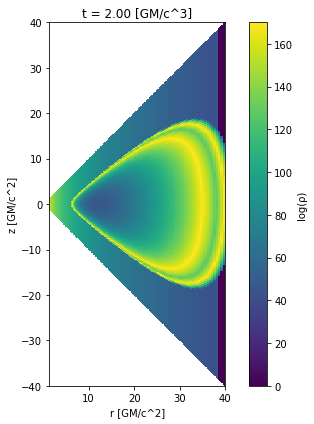

In [42]:
# Quick test plot (adjust filename as needed)
plot_ppm_rz('images/im_lrho_0000.ppm', rdump_path='dumps/rdump0')

In [32]:
MAIN_BASES = ['im_lgam','im_lbsq','im_lu','im_lrho','im_gam','im_bsq','im_u','im_rho']

In [ ]:
# Batch generate MP4s from PPMs for main outputs (both raw and r–z remap)

# --- r–z remap with colorbar ---
def save_rz_png(ppm_path: Path, png_path: Path, grid_params: dict, vmin=None, vmax=None, cmap='viridis'):
    data = ppm_to_scalar(ppm_path)
    N2, N1 = data.shape
    Rin = grid_params['Rin']; Rout = grid_params['Rout']; hslope = grid_params['hslope']; R0 = grid_params['R0']
    DTi = grid_params.get('DTi', 2.0)
    startx1 = np.log(Rin - R0)
    startx2 = 0.0
    dx1 = np.log((Rout - R0) / (Rin - R0)) / N1
    dx2 = 1.0 / N2
    r_e, z_e = compute_cell_edges(N1, N2, startx1, startx2, dx1, dx2, hslope, R0)
    fig, ax = plt.subplots(figsize=(7, 6))
    pcm = ax.pcolormesh(r_e, z_e, data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel('r [GM/c^2]')
    ax.set_ylabel('z [GM/c^2]')
    # Frame time: first image (0000) at t = DTi
    try:
        idx = int(ppm_path.stem.split('_')[-1])
        t_frame = (idx + 1) * DTi
        ax.set_title(f"{ppm_path.name} — t = {t_frame:.2f} [GM/c^2]")
    except Exception:
        ax.set_title(ppm_path.name)
    ax.set_aspect('equal', adjustable='box')
    # Infer quantity from filename
    base_name = '_'.join(ppm_path.stem.split('_')[:-1])  # Remove frame number
    cbar_label = get_quantity_label(base_name)
    fig.colorbar(pcm, ax=ax, label=cbar_label)
    fig.tight_layout()
    fig.savefig(png_path, dpi=150)
    plt.close(fig)

def render_rz_sequence(base_name: str, num_outputs: int, grid_params: dict, src_dir='images', dst_dir='vids', limit=None,
                       vmin=None, vmax=None, cmap='viridis'):
    Path(dst_dir).mkdir(parents=True, exist_ok=True)
    n = num_outputs if limit is None else min(num_outputs, limit)
    for i in range(n):
        ppm_path = Path(src_dir) / f"{base_name}_{i:04d}.ppm"
        png_path = Path(dst_dir) / f"{base_name}_{i:04d}.png"
        if not ppm_path.exists():
            continue
        save_rz_png(ppm_path, png_path, grid_params, vmin=vmin, vmax=vmax, cmap=cmap)

# --- Shared ffmpeg + cleanup ---
def ffmpeg_pngs_to_mp4(base_name: str, dst_dir='vids', framerate=10, overwrite=True):
    mp4_path = Path(dst_dir) / f"{base_name}.mp4"
    cmd = [
        'ffmpeg',
        '-framerate', str(framerate),
        '-i', str(Path(dst_dir) / f"{base_name}_%04d.png"),
        '-c:v', 'libx264',
        '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',
        '-pix_fmt', 'yuv420p',
        str(mp4_path)
    ]
    if overwrite:
        cmd.append('-y')
    subprocess.run(cmd)

def cleanup_pngs(base_name: str, dst_dir='vids'):
    for png in Path(dst_dir).glob(f"{base_name}_*.png"):
        try:
            png.unlink()
        except Exception:
            pass

# --- Batch drivers ---
def batch_ppm_to_mp4_rz(base_names=MAIN_BASES, num_outputs=318, rdump_path='dumps/rdump0', src_dir='images', dst_dir='vids',
                        framerate=10, overwrite=True, cleanup=True, limit=None, vmin=None, vmax=None, cmap='viridis'):
    grid_params = read_rdump_header(rdump_path)
    Path(dst_dir).mkdir(parents=True, exist_ok=True)
    for base in base_names:
        render_rz_sequence(base, num_outputs, grid_params, src_dir=src_dir, dst_dir=dst_dir, limit=limit,
                           vmin=vmin, vmax=vmax, cmap=cmap)
        ffmpeg_pngs_to_mp4(base, dst_dir=dst_dir, framerate=framerate, overwrite=overwrite)
        if cleanup:
            cleanup_pngs(base, dst_dir=dst_dir)

# Examples:
# batch_ppm_to_mp4_raw(num_outputs=num_outputs, limit=10)
# batch_ppm_to_mp4_rz(num_outputs=num_outputs, rdump_path='dumps/rdump0', limit=5)

In [17]:
# # Run batch conversion (r–z remap with colorbar). Set limit=None for full run
# batch_ppm_to_mp4_rz(num_outputs=num_outputs, rdump_path='dumps/rdump0', limit=None) 

In [ ]:
# Faster r–z MP4 writer (streams frames to ffmpeg, no PNGs)
import matplotlib.animation as animation

def stream_rz_to_mp4(base_name: str, num_outputs: int, rdump_path='dumps/rdump0', src_dir='images', out_dir='vids_rz',
                     framerate=10, limit=None, vmin=None, vmax=None, cmap='viridis', dpi=150):
    grid_params = read_rdump_header(rdump_path)
    Rin = grid_params['Rin']; Rout = grid_params['Rout']; hslope = grid_params['hslope']; R0 = grid_params['R0']
    DTi = grid_params.get('DTi', 2.0)

    # Load first available frame to get shape
    n = num_outputs if limit is None else min(num_outputs, limit)
    first_idx = None
    for i in range(n):
        test_path = Path(src_dir) / f"{base_name}_{i:04d}.ppm"
        if test_path.exists():
            first_idx = i
            break
    if first_idx is None:
        print(f"No frames found for {base_name}")
        return

    data0 = ppm_to_scalar(test_path)
    N2, N1 = data0.shape
    startx1 = np.log(Rin - R0)
    startx2 = 0.0
    dx1 = np.log((Rout - R0) / (Rin - R0)) / N1
    dx2 = 1.0 / N2
    r_e, z_e = compute_cell_edges(N1, N2, startx1, startx2, dx1, dx2, hslope, R0)

    Path(out_dir).mkdir(parents=True, exist_ok=True)
    mp4_path = Path(out_dir) / f"{base_name}.mp4"

    fig, ax = plt.subplots(figsize=(7,6))
    quad = ax.pcolormesh(r_e, z_e, data0, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel('r [GM/c^2]'); ax.set_ylabel('z [GM/c^2]'); ax.set_aspect('equal', adjustable='box')
    # Initial title for first frame
    ax.set_title(f"t = {(first_idx + 1) * DTi:.2f} [GM/c^3]")
    cbar_label = get_quantity_label(base_name)
    cbar = fig.colorbar(quad, ax=ax, label=cbar_label)
    fig.tight_layout()

    writer = animation.FFMpegWriter(fps=framerate, codec='libx264', extra_args=['-pix_fmt','yuv420p'])
    with writer.saving(fig, str(mp4_path), dpi):
        for i in range(n):
            ppm_path = Path(src_dir) / f"{base_name}_{i:04d}.ppm"
            if not ppm_path.exists():
                continue
            data = ppm_to_scalar(ppm_path)
            quad.set_array(data.ravel())
            if vmin is not None and vmax is not None:
                quad.set_clim(vmin, vmax)
            # Update title with per-frame time (first frame at t=DTi)
            ax.set_title(f"t = {(i + 1) * DTi:.2f} [GM/c^3]")
            writer.grab_frame()
    plt.close(fig)


# Batch driver for fast streaming r–z
def batch_stream_rz(base_names=MAIN_BASES, num_outputs=318, rdump_path='dumps/rdump0', src_dir='images', out_dir='vids_rz',
                    framerate=10, limit=None, vmin=None, vmax=None, cmap='viridis', dpi=150):
    for base in base_names:
        stream_rz_to_mp4(base, num_outputs, rdump_path=rdump_path, src_dir=src_dir, out_dir=out_dir,
                         framerate=framerate, limit=limit, vmin=vmin, vmax=vmax, cmap=cmap, dpi=dpi)

In [ ]:
batch_stream_rz(base_names=MAIN_BASES, num_outputs=num_outputs, limit=None, out_dir='vids')

In [18]:
# B-field visualization: convert poloidal (r,theta) to cylindrical (r_cyl,z) and plot
def load_b_field_frame(dump_path: str):
    """Parse dump file and extract B1, B2 for all grid points."""
    with open(dump_path, 'r') as f:
        lines = f.readlines()
    
    # Parse header (first line)
    header_vals = [float(x) for x in lines[0].split()]
    N1_file = int(header_vals[1]); N2_file = int(header_vals[2])
    startx1 = header_vals[3]; dx1 = header_vals[5]
    hslope = header_vals[-2]; R0 = header_vals[-1]
    
    # Extract B1, B2 for each cell (skip header, loop over N1*N2 data lines)
    B1 = np.zeros((N2_file, N1_file))
    B2 = np.zeros((N2_file, N1_file))
    
    for idx, line in enumerate(lines[1:N1_file*N2_file+1]):
        vals = [float(x) for x in line.split()]
        i = idx % N1_file
        j = idx // N1_file
        # vals layout: X1, X2, r, th, RHO, UU, U1, U2, U3, B1, B2, B3, divb
        B1[j, i] = vals[9]
        B2[j, i] = vals[10]
    
    return B1, B2, N1_file, N2_file, startx1, dx1, hslope, R0

def plot_bfield_cylindrical(dump_path='dumps/dump000', vmax=None, skip=4):
    """Plot B-field in cylindrical (r_cyl, z) coordinates as quiver plot."""
    B1, B2, N1, N2, startx1, dx1, hslope, R0 = load_b_field_frame(dump_path)
    
    # Compute (r, theta) at cell centers
    i_c = np.arange(N1)
    j_c = np.arange(N2)
    X1c = startx1 + (i_c + 0.5) * dx1
    X2c = (j_c + 0.5) / N2
    X1g, X2g = np.meshgrid(X1c, X2c)
    r, theta = bl_coord_from_X(X1g, X2g, hslope, R0)
    
    # Convert to cylindrical (r_cyl, z)
    r_cyl = r * np.sin(theta)
    z = r * np.cos(theta)
    
    # Convert B from (r, theta) to (r_cyl, z)
    sth = np.sin(theta); cth = np.cos(theta)
    B_r_cyl = B1 * sth + B2 * cth / r
    B_z = B1 * cth - B2 * sth / r
    
    # Plot
    fig, ax = plt.subplots(figsize=(9, 7))
    
    # Color by magnitude
    B_mag = np.sqrt(B_r_cyl**2 + B_z**2)
    scatter = ax.quiver(r_cyl[::skip, ::skip], z[::skip, ::skip],
                        B_r_cyl[::skip, ::skip], B_z[::skip, ::skip],
                        B_mag[::skip, ::skip], cmap='plasma', scale_units='xy', scale=0.15)
    cbar = fig.colorbar(scatter, ax=ax, label='|B|')
    
    ax.set_xlabel('$r_{cyl}$ (cylindrical radius)')
    ax.set_ylabel('$z$ (vertical height)')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Poloidal B-field: (r_cyl, z) components only')
    fig.tight_layout()
    plt.show()

# Example usage:
# plot_bfield_cylindrical(dump_path='dumps/dump000', skip=3)


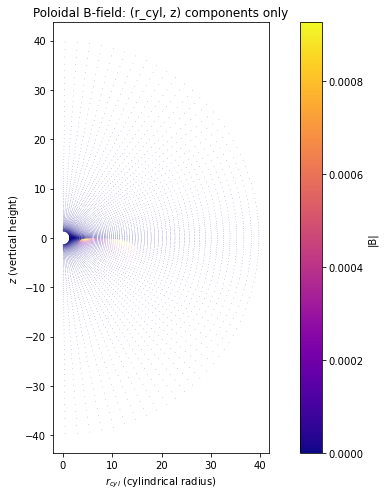

In [19]:
# Test B-field plot on initial dump
plot_bfield_cylindrical(dump_path='dumps/dump000', skip=3)